In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import shap
import seaborn as sns
from scipy.stats import mannwhitneyu
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [6]:
# We will find the important feature for a person that is  'L3' 

In [7]:
# ======= STEP1 =======  - Data Cleaning

In [8]:
df = pd.read_excel("vela_research.xlsx")

In [9]:
df = df[df['num_acquisitions'] < 1] # get rid of the L4, L5

df = df[df['ipo_experience'] == 0]


In [10]:
def replace_labels(lst):
    if isinstance(lst, list):  
        return [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
    elif isinstance(lst, str): 
        lst = eval(lst) if lst.startswith('[') and lst.endswith(']') else [lst]  
        return [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
    return lst  


df['l0l3_persona'] = df['l0l3_persona'].apply(replace_labels)


In [11]:
def replace_labels(lst):
    if isinstance(lst, list):  
        cleaned_lst = [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
        return list(set(cleaned_lst))  
    elif isinstance(lst, str):  
        lst = eval(lst) if lst.startswith('[') and lst.endswith(']') else [lst]  
        cleaned_lst = [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
        return list(set(cleaned_lst))  
    return lst  


df['l0l3_persona'] = df['l0l3_persona'].apply(replace_labels)

In [12]:
df['l0l3_persona'].value_counts()

l0l3_persona
[L2]            4161
[L2, L3]        1333
[L1]            1105
[L3]             764
[L0]             521
[L2, L1]         341
[L2, L0]          69
[L1, L3]          62
[L2, L1, L3]      12
[L0, L3]           1
Name: count, dtype: int64

In [13]:
def transform_persona(persona):
    if isinstance(persona, list) and 'L3' in persona:
        return ['L3']
    return persona  


df['l0l3_persona'] = df['l0l3_persona'].apply(transform_persona)


In [14]:
# here we use the max stuff

df['l0l3_persona'].value_counts()

l0l3_persona
[L2]        4161
[L3]        2172
[L1]        1105
[L0]         521
[L2, L1]     341
[L2, L0]      69
Name: count, dtype: int64

In [15]:
l = ['L3']
filtered_df = df[df['l0l3_persona'].apply(lambda x: x == l)]

df=filtered_df.copy() # the model only has the L2 

In [16]:
df['success'].value_counts() # so around 16% of people were successful 

success
0    1879
1     293
Name: count, dtype: int64

In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()


numeric_columns = df.select_dtypes(include=['number']).columns


threshold = 0.2 * len(df)


filtered_columns = [col for col in numeric_columns if df[col].isna().sum() <= threshold]


df_filtered = df[filtered_columns]

df_filtered = df_filtered.dropna()
df_filtered.drop(columns=['org_total_funding_usd'], inplace=True)
filtered_columns = [col for col in filtered_columns if col != 'org_total_funding_usd']


In [18]:
# ======= STEP2 =======  - Find relevant features using SHAP values from Neural Networks and RandomForest 

In [19]:

# Define important columns
filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered[['success']]

# 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 75% - 25% ( overall 60% - 20% - 20 % )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


y_train = np.array(y_train).ravel()


class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)


weights_dict = {0: class_weights[0], 1: class_weights[1]}




model = Sequential([
    Dense(128, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(32, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss', patience = 5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)



history = model.fit(
    X_train, y_train,
    epochs=100,  
    batch_size=32,
    class_weight=weights_dict,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr], 
    verbose=1
)


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.8).astype(int).flatten()


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


# false positives are more costly than missing out


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4426 - loss: 0.9537 - val_accuracy: 0.5585 - val_loss: 0.8753 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5476 - loss: 0.8534 - val_accuracy: 0.7105 - val_loss: 0.8233 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5723 - loss: 0.8623 - val_accuracy: 0.7018 - val_loss: 0.8013 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.8316 - val_accuracy: 0.6959 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6598 - loss: 0.7774 - val_accuracy: 0.6871 - val_loss: 0.7665 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 0.7755 - val_accuracy: 0.7135 - val_loss: 0.7262 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.7582 - val_accuracy: 0.695

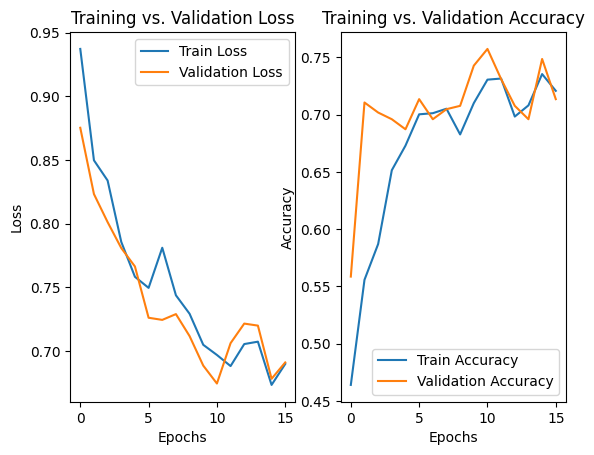

In [20]:
# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')


# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.show()

In [21]:


precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

Precision: 0.6087


In [22]:



tpr = recall_score(y_test, y_pred)

print(f'TPR (Recall): {tpr:.4f}')


TPR (Recall): 0.3256


In [29]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")


AUC-ROC: 0.8502


PermutationExplainer explainer: 343it [00:16,  8.77it/s]                        
/var/folders/qs/0tbv7f593t14wdc49rh246300000gn/T/ipykernel_59159/289828969.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)


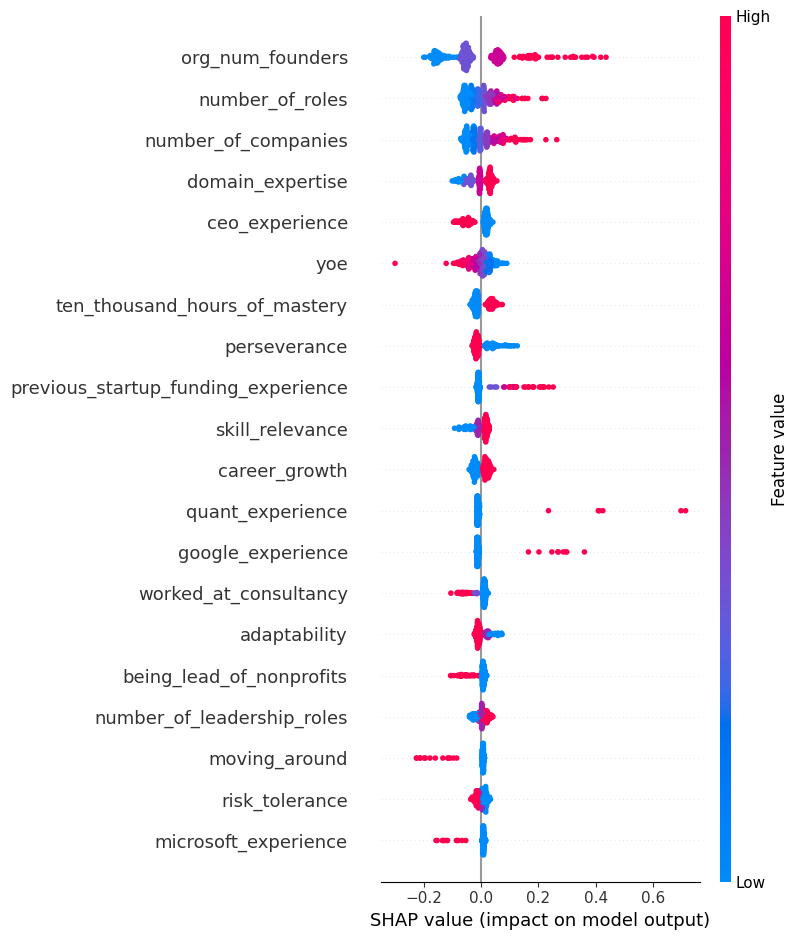

In [23]:

X_test_np = np.array(X_test)
feature_names = filtered_columns

explainer = shap.Explainer(model, X_test_np)
shap_values = explainer(X_test_np)

shap_values.feature_names = feature_names 


plt.figure(figsize=(6, 4))  
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.show()

In [32]:
shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), index=feature_names, columns=["SHAP Value"])
shap_df = shap_df.sort_values(by="SHAP Value", ascending=False)
top_20_features = shap_df.head(20) # select top 20 most influencial features 

In [33]:
top_features_1 = top_20_features.index.to_list()

In [34]:
# we present a general model of Random Forest Classifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'class_weight': {0: 1, 1: 20}, 'max_depth': 10, 'n_estimators': 300}
Validation Accuracy: 0.8304093567251462
Test Accuracy: 0.7836
Confusion Matrix:
[[248  51]
 [ 23  20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       299
           1       0.28      0.47      0.35        43

    accuracy                           0.78       342
   macro avg       0.60      0.65      0.61       342
weighted avg       0.84      0.78      0.80       342



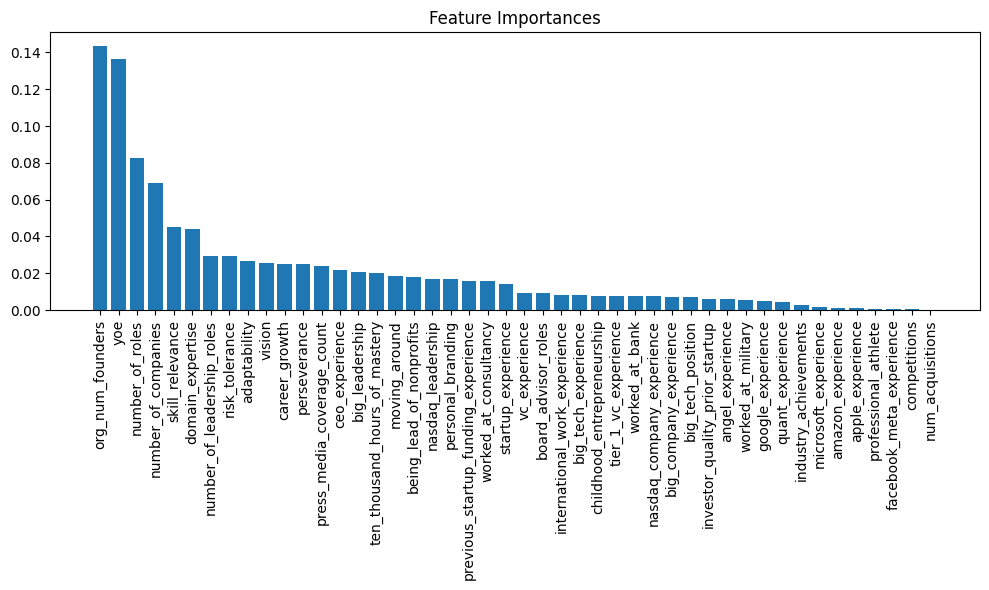

In [35]:


# Define important columns
filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered['success']

# 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 75% - 25% ( overall 60% - 20% - 20 % )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: w} for w in [5, 10, 20]]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)


best_rf_model = grid_search.best_estimator_


y_val_pred = best_rf_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_val_pred))


y_pred = best_rf_model.predict(X_test)




# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot Feature Importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [filtered_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()



In [36]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  

top_20_features = pd.DataFrame({
    "Feature": [filtered_columns[i] for i in indices[:20]],
    "Importance": importances[indices[:20]]
})

top_features_2 = top_20_features['Feature'].to_list()

top_features_2

['org_num_founders',
 'yoe',
 'number_of_roles',
 'number_of_companies',
 'skill_relevance',
 'domain_expertise',
 'number_of_leadership_roles',
 'risk_tolerance',
 'adaptability',
 'vision',
 'career_growth',
 'perseverance',
 'press_media_coverage_count',
 'ceo_experience',
 'big_leadership',
 'ten_thousand_hours_of_mastery',
 'moving_around',
 'being_lead_of_nonprofits',
 'nasdaq_leadership',
 'personal_branding']

In [37]:
# Random Forest focused on precision, here we change 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

Best Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': None, 'n_estimators': 100}
Validation Accuracy: 0.8742690058479532
Validation Precision: 1.0
Test Accuracy: 0.8772
Confusion Matrix:
[[297   1]
 [ 41   3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       298
           1       0.75      0.07      0.12        44

    accuracy                           0.88       342
   macro avg       0.81      0.53      0.53       342
weighted avg       0.86      0.88      0.83       342



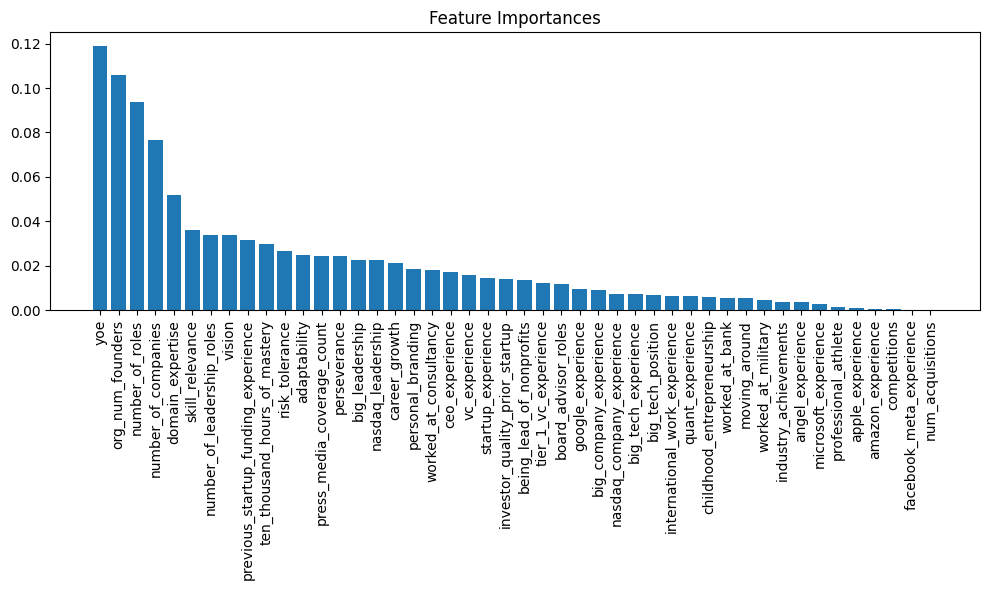

In [38]:



filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered['success']

# Same split as above 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: w} for w in [5, 10, 20]]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='precision', cv=5, verbose=2, n_jobs=-1) # we change here to 'precision'
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)


best_rf_model = grid_search.best_estimator_


y_val_pred = best_rf_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_val_pred))
print('Validation Precision:', precision_score(y_val, y_val_pred))


y_pred = best_rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [filtered_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [39]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort in descending order

# top 20 features and their importance values
top_20_features = pd.DataFrame({
    "Feature": [filtered_columns[i] for i in indices[:20]],
    "Importance": importances[indices[:20]]
})

top_features_3 =  top_20_features['Feature'].to_list()

In [40]:
top_features_2_final =  list(set(top_features_2) & set(top_features_3)) 

top_features_2_final # the interesection between the feature importance of these 2 models

['adaptability',
 'nasdaq_leadership',
 'risk_tolerance',
 'yoe',
 'number_of_companies',
 'number_of_roles',
 'ten_thousand_hours_of_mastery',
 'perseverance',
 'press_media_coverage_count',
 'vision',
 'number_of_leadership_roles',
 'ceo_experience',
 'personal_branding',
 'domain_expertise',
 'skill_relevance',
 'big_leadership',
 'career_growth',
 'org_num_founders']

In [41]:
top_features = list(set(top_features_1) & set(top_features_2_final)) 

In [42]:
# ======= STEP3 =======  - Find how relevant this features are to our prediction

In [43]:
top_features

['adaptability',
 'risk_tolerance',
 'number_of_companies',
 'yoe',
 'number_of_roles',
 'ten_thousand_hours_of_mastery',
 'perseverance',
 'ceo_experience',
 'number_of_leadership_roles',
 'domain_expertise',
 'skill_relevance',
 'career_growth',
 'org_num_founders']

In [44]:
# Here we apply Man Whitney test for each column and separate the data in 2 sets: people with success and people that failed 

In [45]:
# Also we will print for each column the count for each value for when people succeed and when people failed 

In [46]:


count_ones = (df_filtered['success'] == 1).sum()

threshold = 15
final = []

if threshold * count_ones > len(df_filtered) and len(df_filtered) > 25:
    for col in top_features:
        
        print(f'The values for this {col} is (success) ' , df_filtered[df_filtered['success']==1][col].value_counts())
        print(f'The values for this {col} is (failure) ' , df_filtered[df_filtered['success']==0][col].value_counts())
        successful = df_filtered[df_filtered['success'] == 1][col]
        unsuccessful = df_filtered[df_filtered['success'] == 0][col]

        # Perform the Mann-Whitney U test
        if len(successful) > 0 and len(unsuccessful) > 0:
            stat, p_value = mannwhitneyu(successful, unsuccessful, alternative='two-sided')

            # Interpretation
            if p_value < 0.05:
                print(f"The distributions of '{col}' differ based on success. ✅")
                final.append(col)
            else:
                print(f"No significant difference in the distributions of '{col}'. ❌")
            print('\n')
        else:
            print(f"Not enough data to perform the test for '{col}'.")
else:
    print('Sorry, not enough data')


The values for this adaptability is (success)  adaptability
2.0    172
1.0     32
0.0     18
Name: count, dtype: int64
The values for this adaptability is (failure)  adaptability
2.0    1089
1.0     259
0.0     138
Name: count, dtype: int64
No significant difference in the distributions of 'adaptability'. ❌


The values for this risk_tolerance is (success)  risk_tolerance
2.0    97
0.0    90
1.0    35
Name: count, dtype: int64
The values for this risk_tolerance is (failure)  risk_tolerance
2.0    643
0.0    619
1.0    224
Name: count, dtype: int64
No significant difference in the distributions of 'risk_tolerance'. ❌


The values for this number_of_companies is (success)  number_of_companies
2.0     43
1.0     38
3.0     34
5.0     27
0.0     26
4.0     18
8.0     10
7.0      9
6.0      6
9.0      4
10.0     3
11.0     3
13.0     1
Name: count, dtype: int64
The values for this number_of_companies is (failure)  number_of_companies
0.0     447
1.0     365
2.0     204
3.0     144
4.0     1

In [47]:
final

['number_of_companies',
 'number_of_roles',
 'ten_thousand_hours_of_mastery',
 'ceo_experience',
 'number_of_leadership_roles',
 'domain_expertise',
 'skill_relevance',
 'career_growth',
 'org_num_founders']

[CV] END class_weight={0: 1, 1: 5}, max_depth=None, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1, 1: 5}, max_depth=None, n_estimators=200; total time=   0.4s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, n_estimators=200; total time=   0.5s
[CV] END class_weight={0: 1, 1: 5}, max_depth=20, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1, 1: 5}, max_depth=20, n_estimators=200; total time=   0.3s
[CV] END class_weight={0: 1, 1: 10}, max_depth=None, n_estimators=100; total time=   0.3s
[CV] END class_weight={0: 1, 1: 10}, max_depth=None, n_estimators=100; total time=   0.4s
[CV] END class_weight={0: 1, 1: 10}, max_depth=None, n_estimators=200; total time=   0.4s
[CV] END class_weight={0: 1, 1: 10}, max_depth=10, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1, 